In [1]:

from dotenv import load_dotenv
load_dotenv()
import scllm as sl
import scanpy as sc
import pandas as pd
from langchain_openai import ChatOpenAI

# Annotate cell types

## PBMC dataset


In this tutorial we will use Chat GPT to annotate cell types.

In [2]:
pbmc = sc.datasets.pbmc3k_processed()

In [3]:
openai_model = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0.0, model=openai_model)

In [4]:
pbmc

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [5]:
sc.tl.leiden(pbmc, flavor="igraph", n_iterations=2)

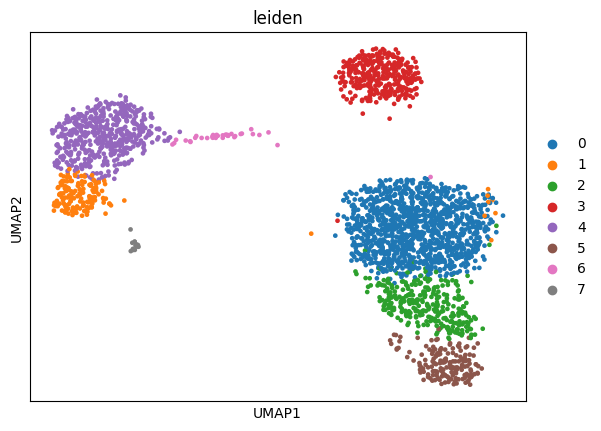

In [6]:
sc.pl.umap(pbmc, color='leiden')

To annotate the cells we simply use the `annotate_cluster` function. This will iterate through each cluster and try to determine the most likely cell types.

In [7]:
sl.tl.annotate_cluster(pbmc, 'leiden', llm, use_raw=True, top_genes=30, num_samples=10)

In [8]:
pbmc.uns['scllm_leiden']

,cluster,init,target
0,0,0,T cell
1,1,1,T cell
2,2,2,T cell
3,3,3,T cell
4,4,4,T cell
...,...,...,...
75,5,5,Platelet
76,6,6,Platelet
77,7,7,Platelet
78,8,8,Platelet


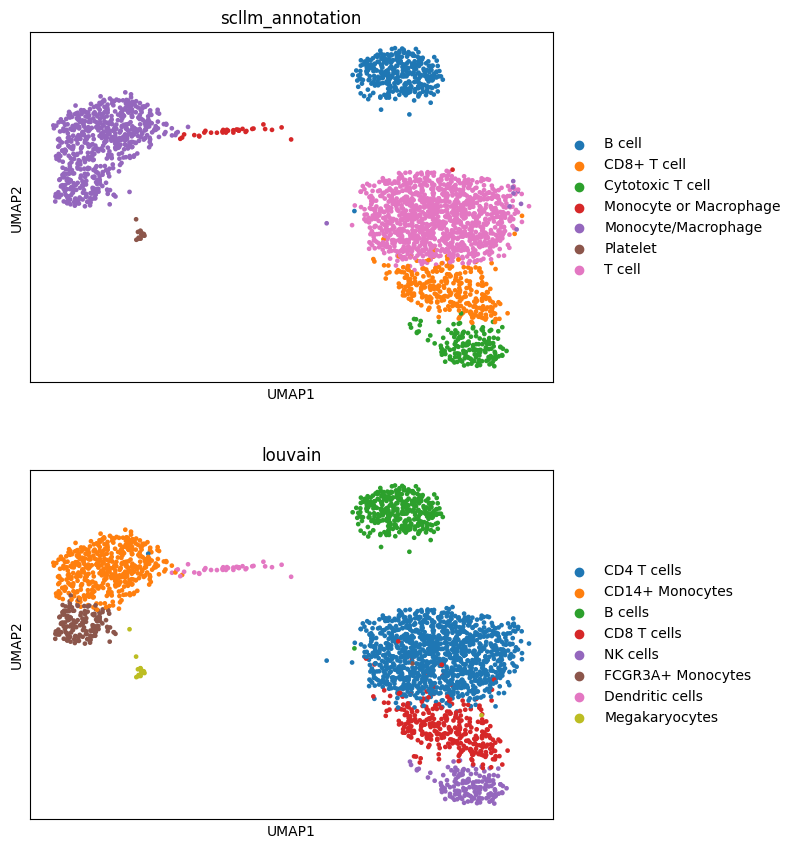

In [9]:
sc.pl.umap(pbmc, color=['scllm_annotation', 'louvain'], ncols=1)

## Angelidis

In this example we will use the `annotate_cluster` function to annotate the cells in the Angelidis dataset.

In [7]:
angelidis = sc.read_h5ad('/Users/harald/Downloads/umap_1.h5ad')

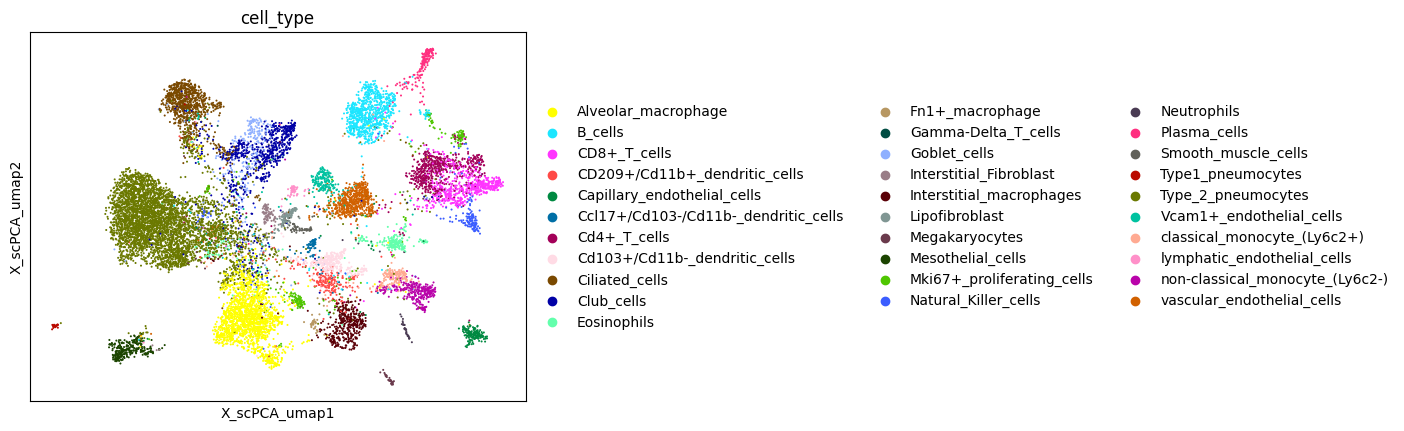

In [8]:
sc.pl.embedding(angelidis, 'X_scPCA_umap', color='cell_type')

In [18]:
sc.tl.leiden(angelidis, flavor="igraph", n_iterations=2, neighbors_key='X_scPCA')

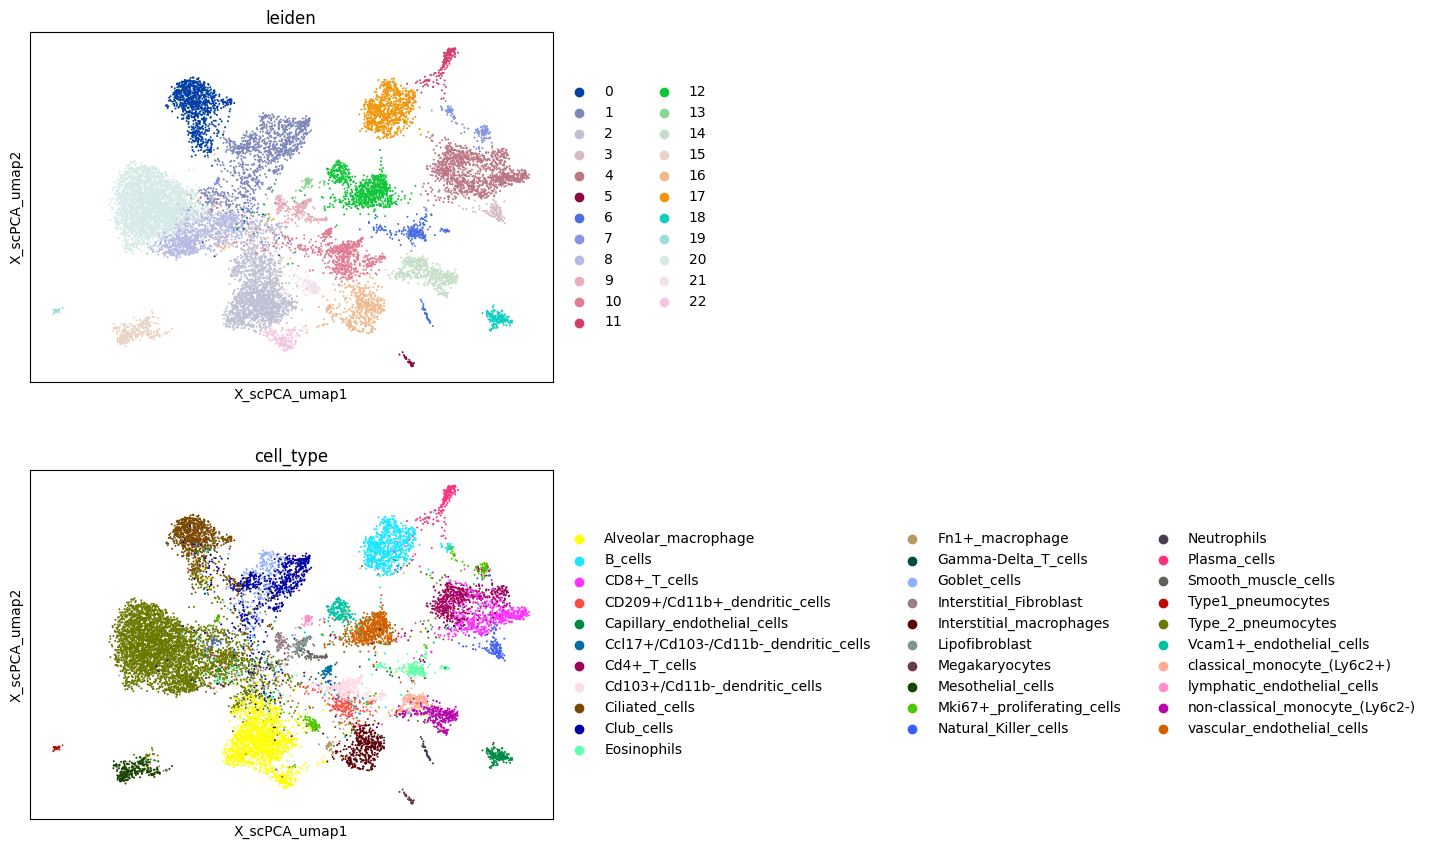

In [20]:
sc.pl.embedding(angelidis, basis='X_scPCA_umap', color=['leiden', 'cell_type'], ncols=1)

In [27]:
angelidis.layers['log1p'] = sc.pp.log1p(angelidis.layers['counts'])

In [28]:
sl.tl.annotate_cluster(angelidis, 'leiden', llm, top_genes=30, num_samples=20, layer='log1p', method='wilcoxon')

/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.

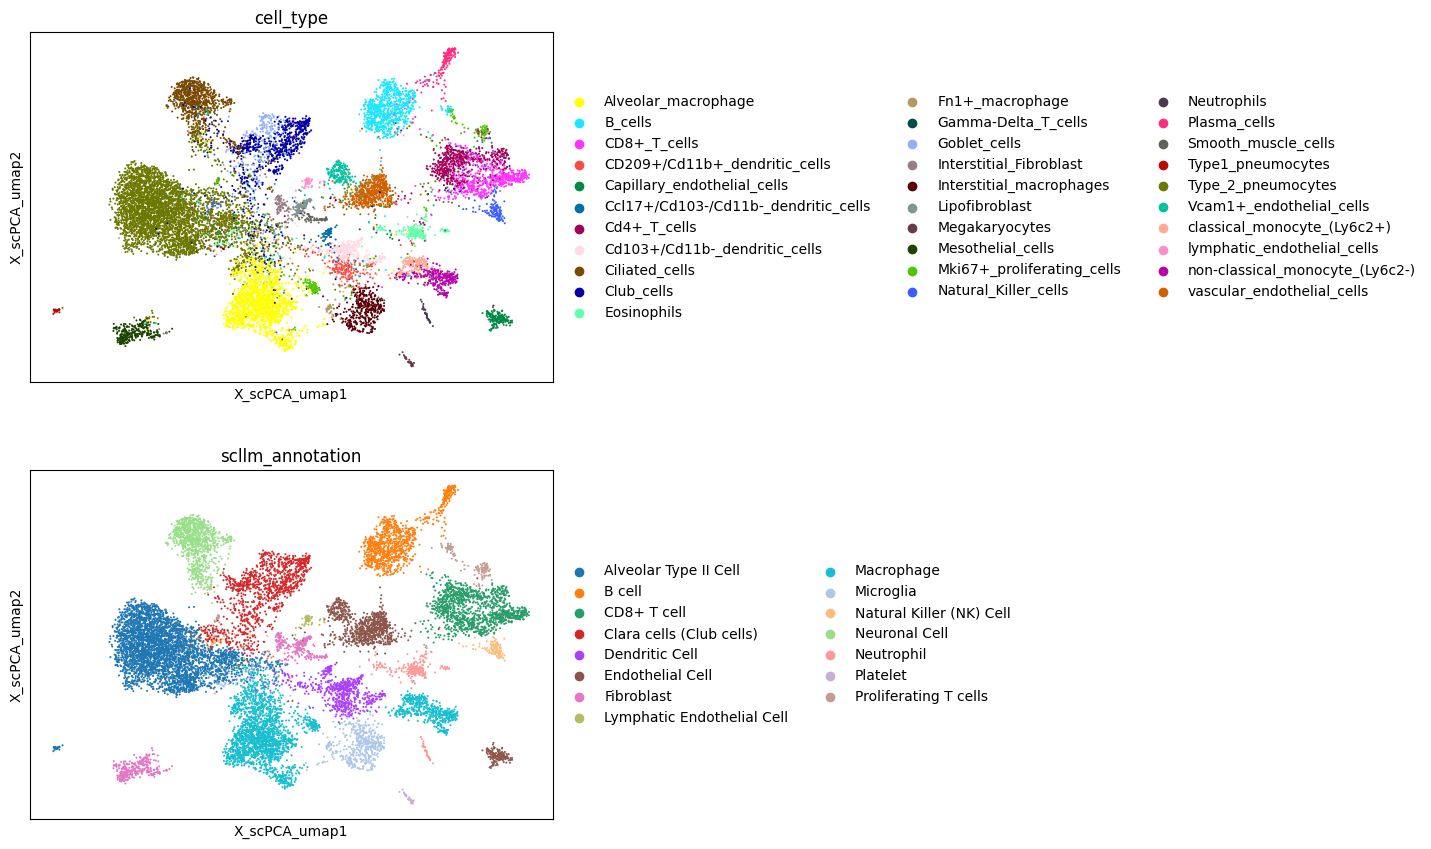

In [35]:
sc.pl.embedding(angelidis, basis='X_scPCA_umap', color=['cell_type', 'scllm_annotation'], ncols=1)